In [83]:
import paltas
from paltas.Analysis import hierarchical_inference
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, truncnorm, uniform, beta
import emcee
import corner
import numba
import pandas as pd
import os

np.random.seed(4)
# REQUIRED IMPORTS
# FILE MANAGEMENT
import h5py
import os
from IPython.utils import io

%load_ext autoreload
%autoreload 2

# DATA MANIPULATION
import numpy as np
import pandas as pd

# PALTAS FUNCTIONS
import network_predictions
import paltas
from paltas import generate

# VISUALIZATION
import matplotlib
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
import visualization_utils
import matplotlib.colors as mpc
import corner
from matplotlib.patches import Patch
import astropy.visualization as asviz


SMALL_SIZE = 17
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

# MACHINE LEARNING
import tensorflow as tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Running Hierarchical Inference on a Population of Strong Lenses


#### Loading in train and test data

In [2]:
train_data = pd.read_csv('generated_images/no_lens/config_LSST/metadata.csv',usecols=np.arange(9,61))
valid_data =pd.read_csv('generated_images/no_lens_valid/config_LSST/metadata.csv', usecols=np.arange(9,61)) 
test_data = pd.read_csv('generated_images/test/config_LSST_catalog/metadata.csv',usecols=np.arange(9,61)) 
n_lenses = len(test_data)

In [3]:
# LOAD IN WEIGHTS; 
# DESCRIBE THE WEIGHTS: trained with no lens light; normalization used while training: (image - mean) / std
path_to_weights = 'NLNORM/model_weights3/_23--1.86_best.h5'
path_to_norms = 'generated_images/no_lens/config_LSST/norms.csv'
results_folder = 'NLNORM'
# trained.model is gonna take all the inputs, do all the calculations and gives you output on your test object
# it is the trained nn
# precision is inverse of covariance matrix
# LOAD IN THE WEIGHTS
# SETTING THE LEARNING PARAMS USES THE DEFAULT PARAMS: 'main_deflector_parameters_theta_E',
                                                    #  'main_deflector_parameters_gamma1',
                                                    #  'main_deflector_parameters_gamma2',
                                                    #  'main_deflector_parameters_gamma',
                                                    #  'main_deflector_parameters_e1',
                                                    #  'main_deflector_parameters_e2',
                                                    #  'main_deflector_parameters_center_x',
                                                    #  'main_deflector_parameters_center_y'
trained = network_predictions.NetworkPredictions(path_to_model_weights=path_to_weights,
                                                 path_to_model_norms=path_to_norms,
                                                 learning_params=None,
                                                 loss_type='diag',
                                                 model_type='xresnet34',
                                                 norm_type='stdnorm')

with io.capture_output() as captured:

    y_test, y_pred, std_pred, prec_pred, log_var_pred = trained.gen_network_predictions('generated_images/test/config_LSST_catalog/',samples=False,shuffle=False);

In [4]:
prec_pred

array([[[ 630.43406753,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,  289.8625896 ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,  263.66778115, ...,
            0.        ,    0.        ,    0.        ],
        ...,
        [   0.        ,    0.        ,    0.        , ...,
           48.43560597,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,  636.9076528 ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,  553.90361671]],

       [[  16.3716344 ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,  115.66662206,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,  119.17413395, ...,
            0.

In [5]:
# assign each param a label for visualization
labels = dict(zip(trained.learning_params, ["$\\theta_E$", "$\gamma_1$", "$\gamma_2$", "$\gamma_{lens}$", "$e_1$", "$e_2$", "$x_{D}$", "$y_{D}$"]))

Sydney notes: end goal with HI - infering hypermodel parameters that describe the gaussian distributions of einstein radius

In [6]:
import sys
sys.path.insert(0, '/Users/padmavenkatraman/Documents/StrongLensing/deep-lens-modeling/')
from Inference import network_hierarchical_inference as bhi

In [7]:
trained.learning_params = trained.learning_params[:6]

In [8]:
# Let's define a few of the parameters for our inference
n_lenses = len(test_data)
n_emcee_samps = 1000

# Load the predictions for the mean and covariance for our model. We'll have to do a little reshaping here since the code
# expect an array of mean values and a precision matrix.

# The interim training distribution.
mu_train = np.array(train_data[trained.learning_params].mean())
cov_train = np.array(train_data[trained.learning_params].cov())
std_train = np.array(train_data[trained.learning_params].std())
mu_test = np.array(test_data[trained.learning_params].mean())
cov_test = np.array(test_data[trained.learning_params].cov())
std_test = np.array(test_data[trained.learning_params].std())

In [9]:
len(mu_test), len(mu_train)

(6, 6)

#### We want to first visualize what our test and train distributions look like
1. The training set is generated from parameters sampled from an "interim prior". I sometimes refer to this as the training prior or the training distribution
2. The true population of lenses or the simulated OM10 catalog is generated from parameters drawn from test distribution. We fit a gaussian to this distribution and sample from that.

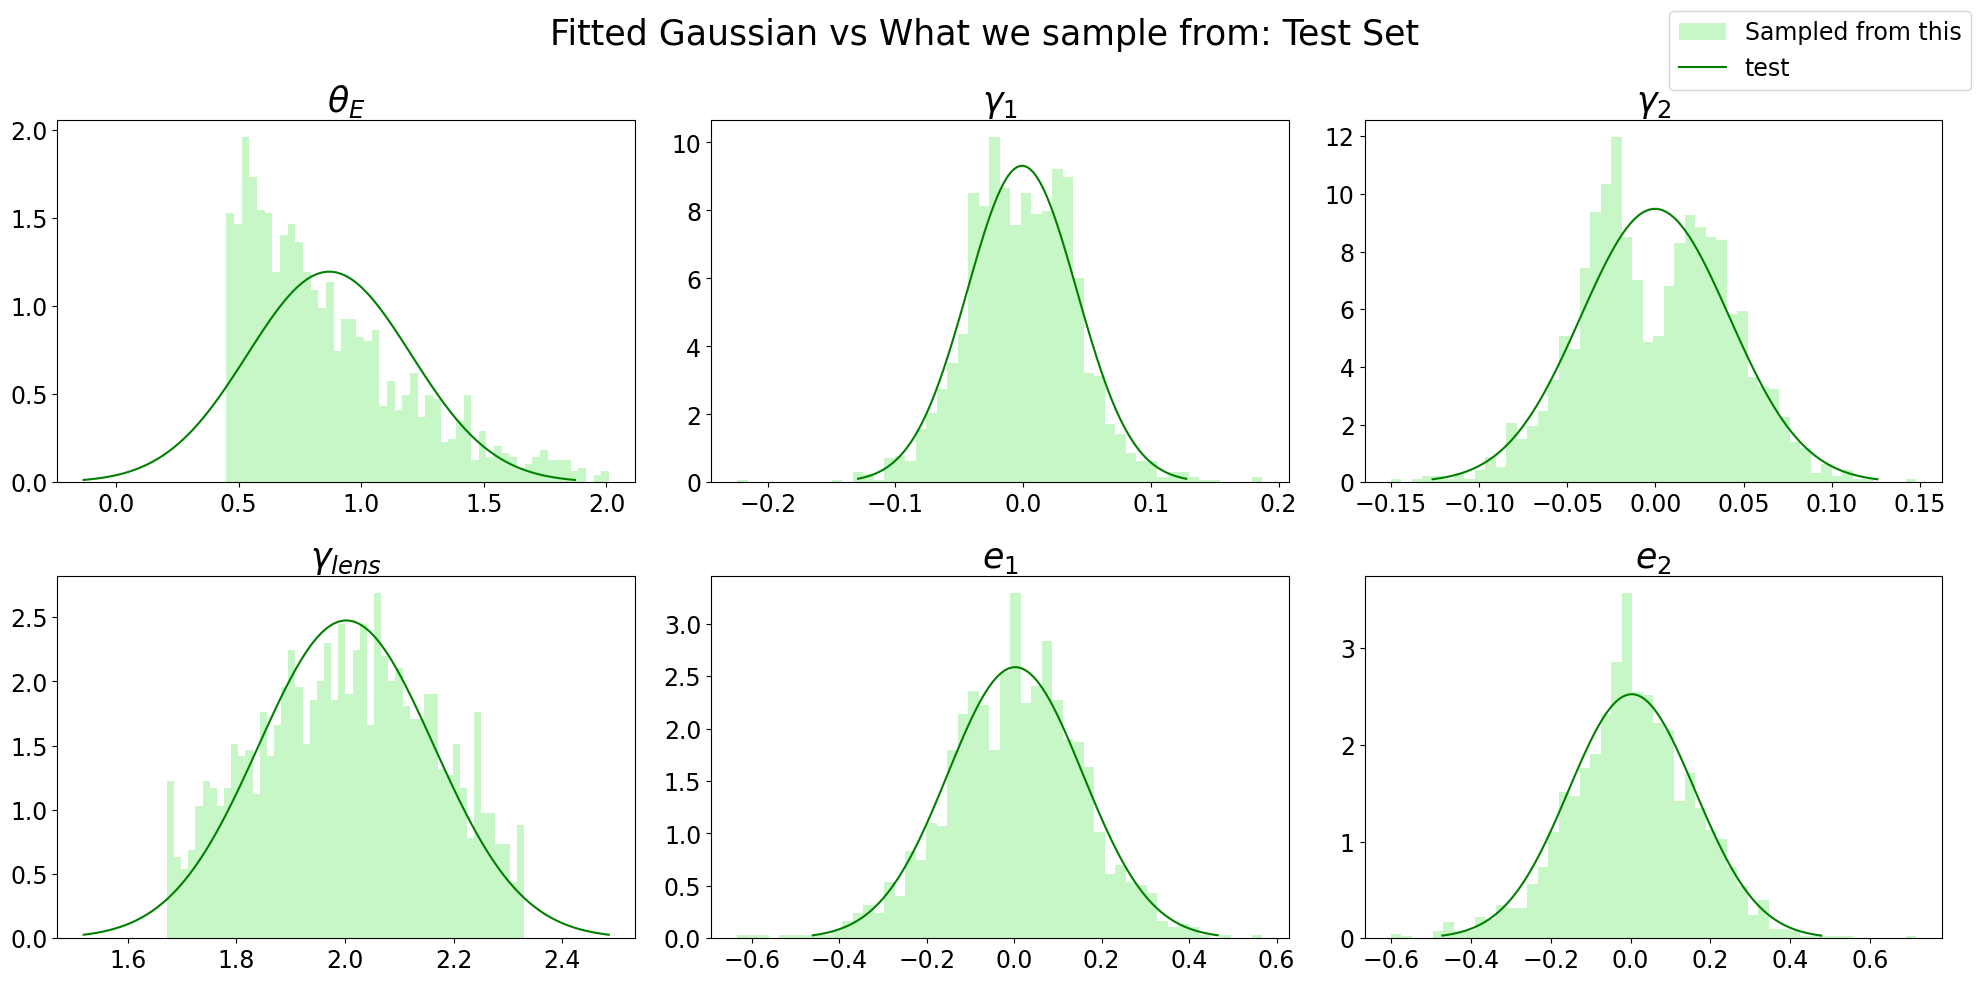

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax = ax.flatten()
for i in range(6):
    mutest = mu_test[i]
    mutrain = mu_train[i]
    sigmatest = std_test[i]
    sigmatrain = std_train[i]
    xtest = np.linspace(mutest - 3*sigmatest, mutest + 3*sigmatest, 100)
    # xtrain = np.linspace(mutrain - 3*sigmatrain, mutrain + 3*sigmatrain, 100)
    ax[i].hist(test_data[trained.learning_params[i]], density=True, bins=50,color='lightgreen', label='Sampled from this', alpha=0.5)
    ax[i].plot(xtest, norm.pdf(xtest, mutest, sigmatest),label='test', color='g')
    # ax[i].plot(xtrain, norm.pdf(xtrain, mutrain, sigmatrain), label='train', color='b')
    ax[i].set_title(labels[trained.learning_params[i]])
handles, lbls = fig.gca().get_legend_handles_labels()
by_label = dict(zip(lbls, handles))
fig.legend(by_label.values(), by_label.keys())
fig.suptitle("Fitted Gaussian vs What we sample from: Test Set")
fig.tight_layout()



In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax = ax.flatten()
for i in range(6):
    mutest = mu_test[i]
    mutrain = mu_train[i]
    sigmatest = std_test[i]
    sigmatrain = std_train[i]
    xtest = np.linspace(mutest - 3*sigmatest, mutest + 3*sigmatest, 100)
    # xtrain = np.linspace(mutrain - 3*sigmatrain, mutrain + 3*sigmatrain, 100)
    ax[i].hist(test_data[trained.learning_params[i]], density=True, bins=50,color='lightgreen', label='Sampled from this', alpha=0.5)
    ax[i].plot(xtest, norm.pdf(xtest, mutest, sigmatest),label='test', color='g')
    # ax[i].plot(xtrain, norm.pdf(xtrain, mutrain, sigmatrain), label='train', color='b')
    ax[i].set_title(labels[trained.learning_params[i]])
handles, lbls = fig.gca().get_legend_handles_labels()
by_label = dict(zip(lbls, handles))
fig.legend(by_label.values(), by_label.keys())
fig.suptitle("Fitted Gaussian vs What we sample from: Test Set")
fig.tight_layout()

    

In [11]:
np.mean(y_test[:, 3])

2.0021129

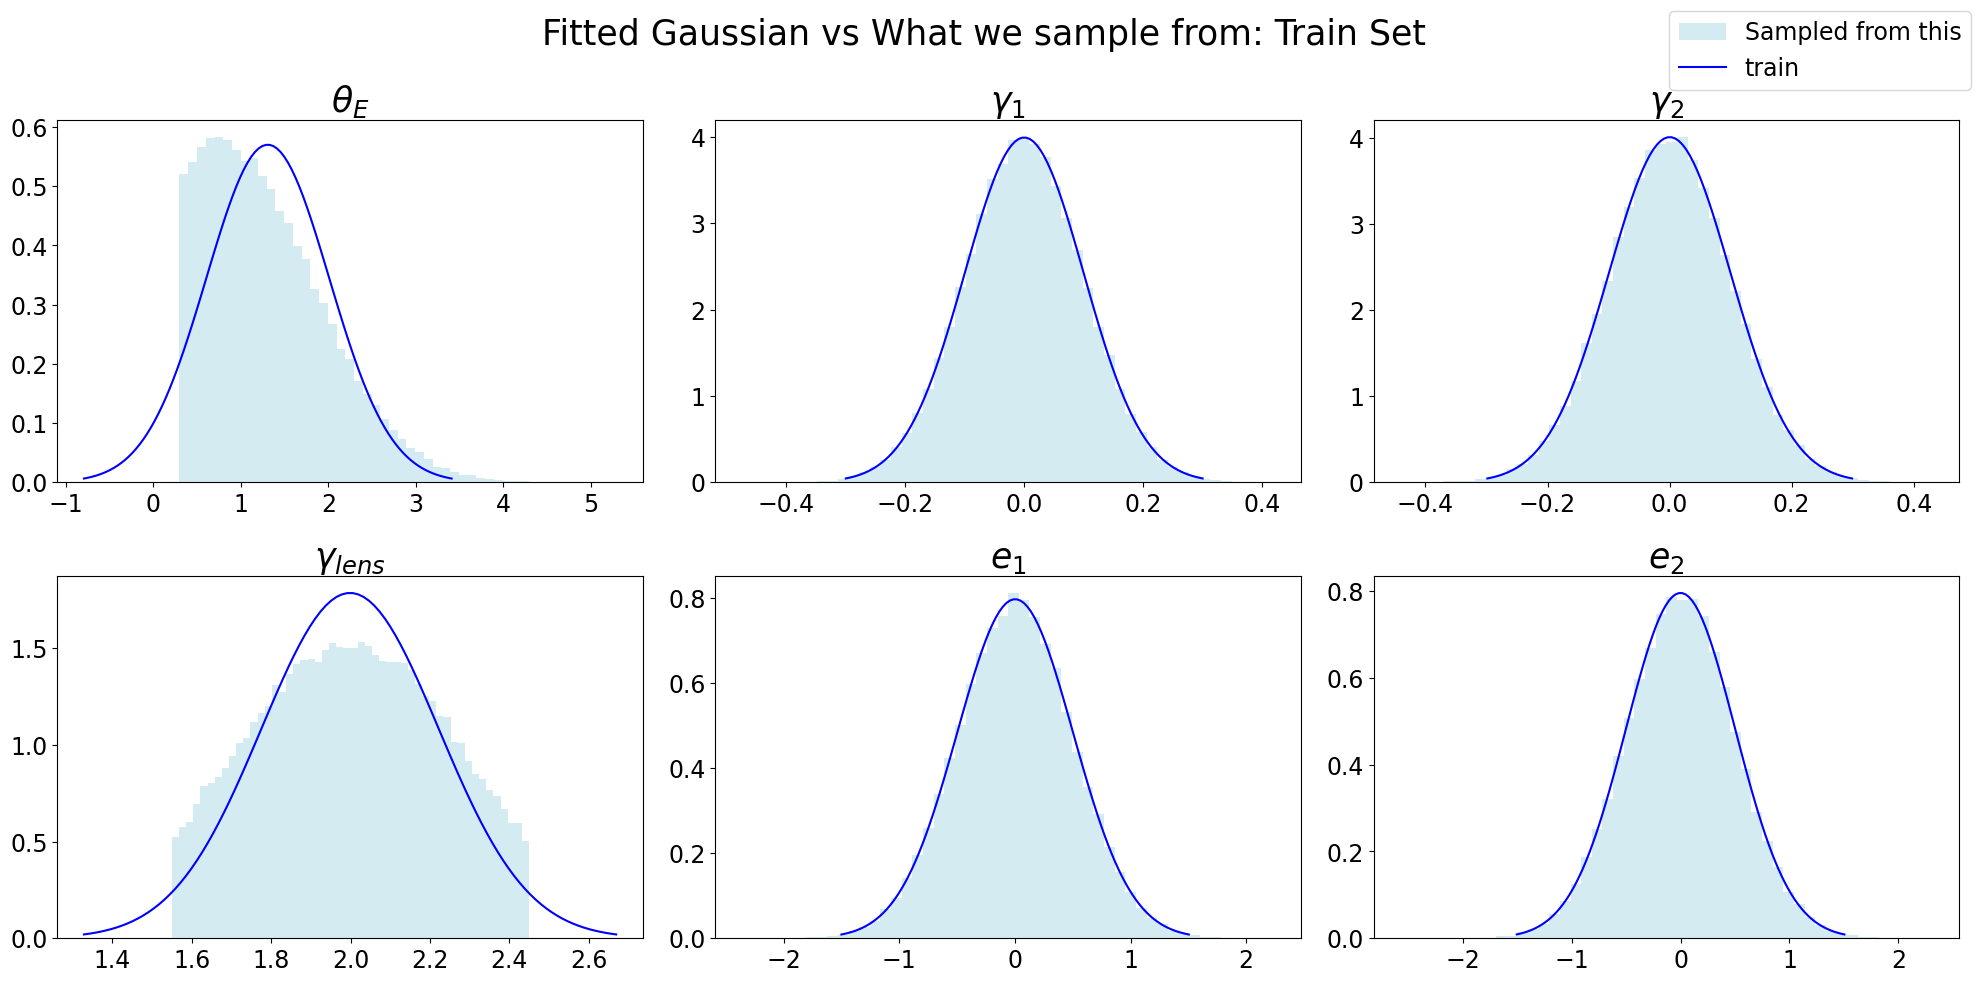

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax = ax.flatten()
for i in range(6):
    mutest = mu_test[i]
    mutrain = mu_train[i]
    sigmatest = std_test[i]
    sigmatrain = std_train[i]
    # xtest = np.linspace(mutest - 3*sigmatest, mutest + 3*sigmatest, 100)
    xtrain = np.linspace(mutrain - 3*sigmatrain, mutrain + 3*sigmatrain, 100)
    ax[i].hist(train_data[trained.learning_params[i]], density=True, bins=50,color='lightblue', label='Sampled from this', alpha=0.5)
    # ax[i].plot(xtest, norm.pdf(xtest, mutest, sigmatest),label='test', color='g')
    ax[i].plot(xtrain, norm.pdf(xtrain, mutrain, sigmatrain), label='train', color='b')
    ax[i].set_title(labels[trained.learning_params[i]])
handles, lbls = fig.gca().get_legend_handles_labels()
by_label = dict(zip(lbls, handles))
fig.legend(by_label.values(), by_label.keys())
fig.suptitle("Fitted Gaussian vs What we sample from: Train Set")
fig.tight_layout()



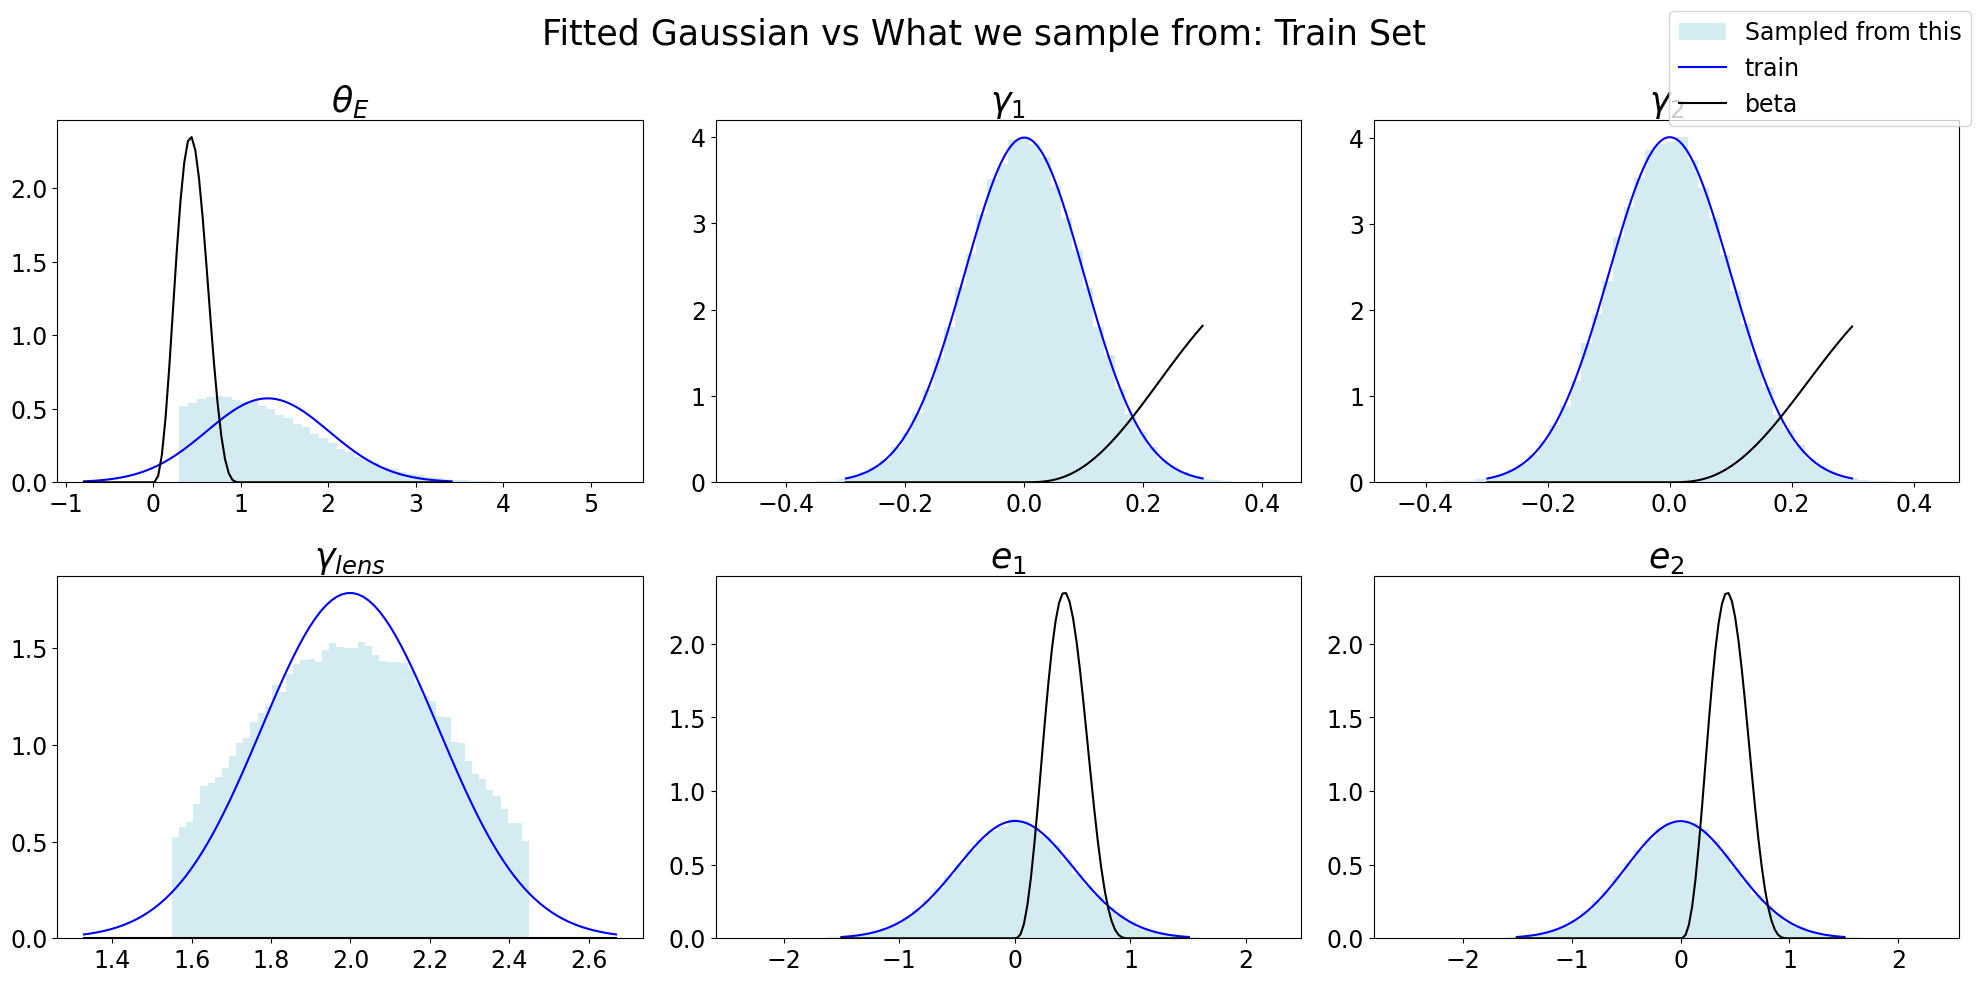

In [89]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax = ax.flatten()
for i in range(6):
    mutest = mu_test[i]
    mutrain = mu_train[i]
    sigmatest = std_test[i]
    sigmatrain = std_train[i]
    # xtest = np.linspace(mutest - 3*sigmatest, mutest + 3*sigmatest, 100)
    xtrain = np.linspace(mutrain - 3*sigmatrain, mutrain + 3*sigmatrain, 100)
    ax[i].hist(train_data[trained.learning_params[i]], density=True, bins=50,color='lightblue', label='Sampled from this', alpha=0.5)
    # ax[i].plot(xtest, norm.pdf(xtest, mutest, sigmatest),label='test', color='g')
    ax[i].plot(xtrain, norm.pdf(xtrain, mutrain, sigmatrain), label='train', color='b')
    ax[i].plot(xtrain, beta.pdf(xtrain, 4, 5), label='beta', color='k')
    ax[i].set_title(labels[trained.learning_params[i]])
handles, lbls = fig.gca().get_legend_handles_labels()
by_label = dict(zip(lbls, handles))
fig.legend(by_label.values(), by_label.keys())
fig.suptitle("Fitted Gaussian vs What we sample from: Train Set")
fig.tight_layout()



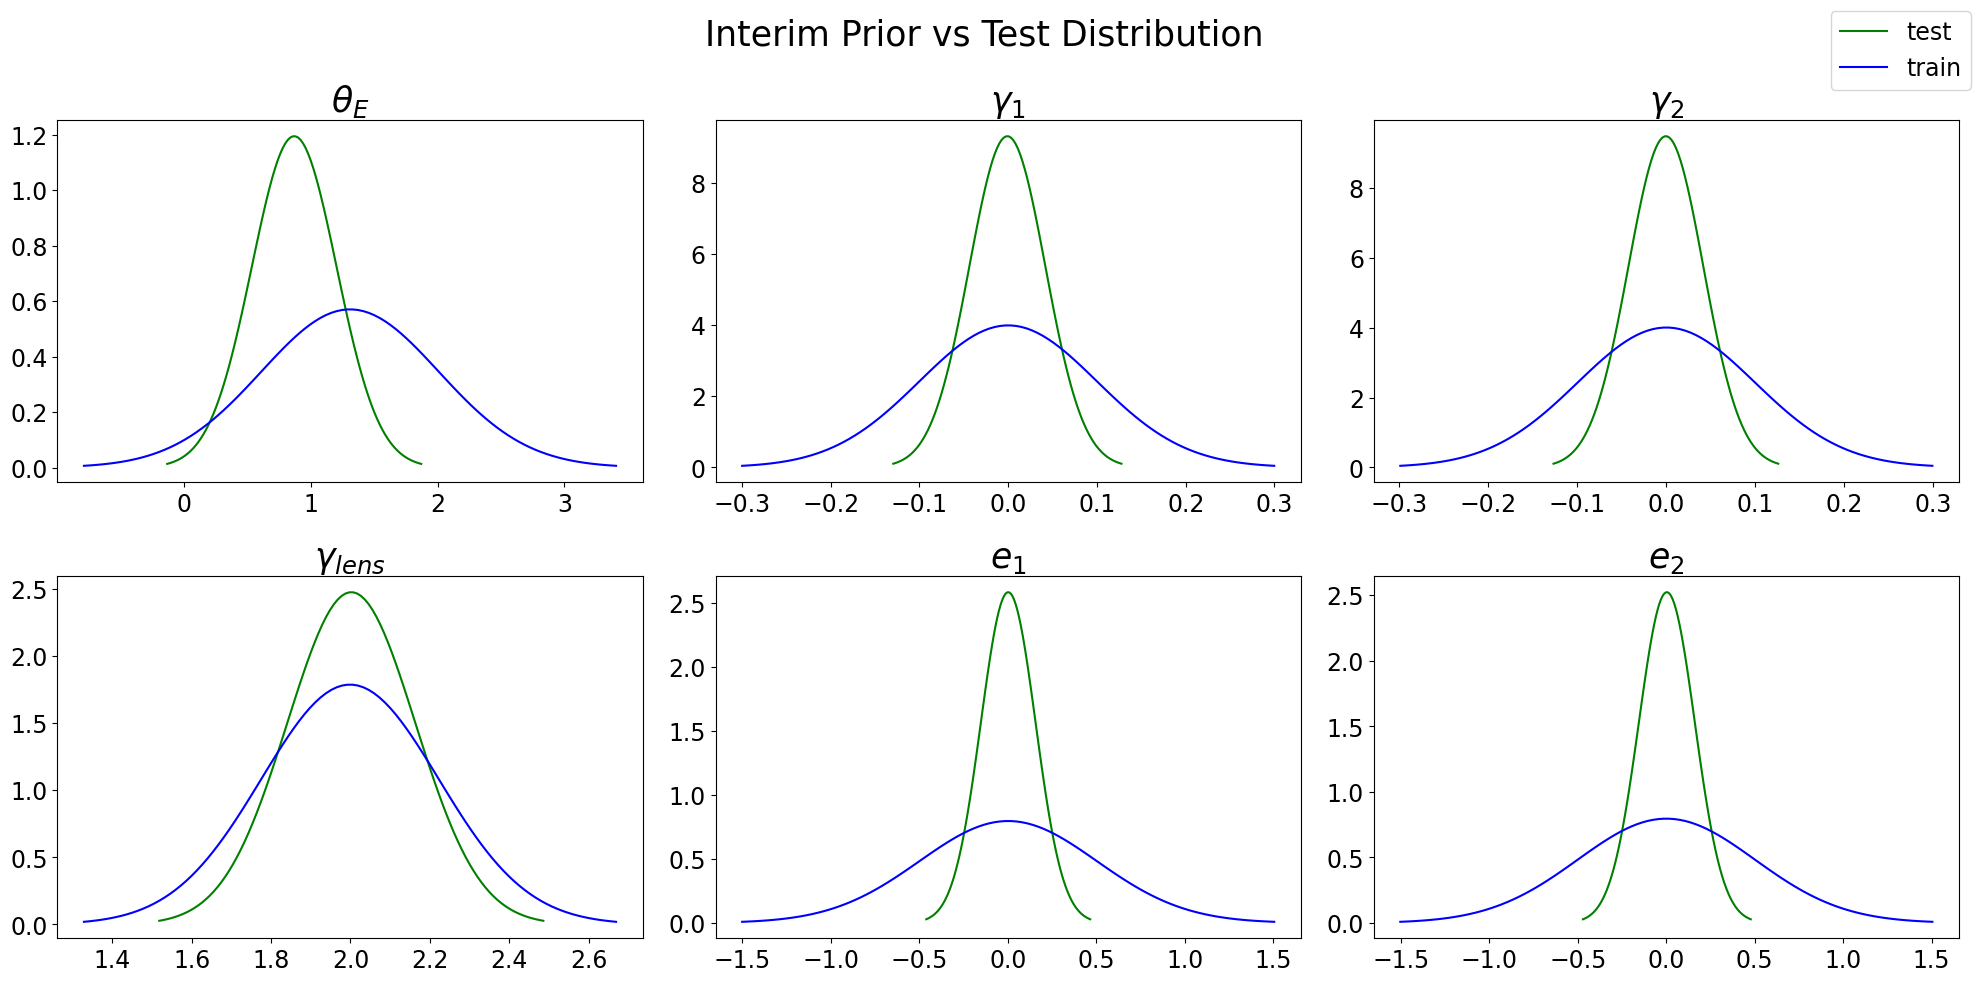

In [85]:

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax = ax.flatten()
for i in range(6):
    mutest = mu_test[i]
    mutrain = mu_train[i]
    sigmatest = std_test[i]
    sigmatrain = std_train[i]
    xtest = np.linspace(mutest - 3*sigmatest, mutest + 3*sigmatest, 100)
    xtrain = np.linspace(mutrain - 3*sigmatrain, mutrain + 3*sigmatrain, 100)
    ax[i].plot(xtest, norm.pdf(xtest, mutest, sigmatest),label='test', color='g')
    ax[i].plot(xtrain, norm.pdf(xtrain, mutrain, sigmatrain), label='train', color='b')
    ax[i].set_title(labels[trained.learning_params[i]])
handles, lbls = fig.gca().get_legend_handles_labels()
by_label = dict(zip(lbls, handles))
fig.legend(by_label.values(), by_label.keys())
fig.suptitle("Interim Prior vs Test Distribution")
fig.tight_layout()



In [14]:
std_train

array([0.69961883, 0.09988944, 0.09959528, 0.22337998, 0.50079495,
       0.50137579])

In [15]:
np.sum(std_pred[:, :6]>np.array([0.7, 0.1, 0.1,0.22, 0.5, 0.5]))

65

In [16]:
prec_pred[:, :6, :6].shape

(1556, 6, 6)

In [33]:
lower = np.concatenate((mu_test - std_test, np.ones(6)*0.01))
upper = np.concatenate((mu_test + std_test, std_train))
HI_obj = bhi.NetworkHierarchicalInference(y_train = mu_train,
                                   std_train = std_train,
                                   y_pred_list = [y_pred[:, :6]],
                                   prec_pred_list = [prec_pred[:, :6, :6]],
                                   hypermodel_type = 'regular',
                                   method = 'analytical',
                                   sigmas_log_uniform = False,
                                   n_emcee_samps = 2000,
                                   initial_state_bounds = (lower, upper)
                                   )
HI_obj

I'm going to assert that the initial state should contain starting points for the means within one sigma of the test distribution of the mean, and that the standard deviation of the distribution can have a lower limit of 0.01 and an upper limit of the standard deviation of the training prior.

In [34]:
HI_obj.n_walkers

40

In [37]:
chain_list = HI_obj.run_HI(chains_filepath=None)

[ 0.53515143 -0.04369099 -0.04229717  1.84087523 -0.15170088 -0.15488729
  0.01        0.01        0.01        0.01        0.01        0.01      ] [1.20309526 0.04196307 0.04180969 2.16335056 0.15689843 0.16128803
 0.69961883 0.09988944 0.09959528 0.22337998 0.50079495 0.50137579]


100%|██████████| 2000/2000 [11:46<00:00,  2.83it/s]


In [41]:
emcee_chain = chain_list[0]

In [42]:
a = '$\mu_'
b = '{\gamma_{lens}}$'


In [43]:
mu_labels = ['$\mu_' + '{' + i[1:-1] + '}$' for i in list(labels.values())]

std_labels = ['$\sigma_' + '{' + i[1:-1] + '}$' for i in list(labels.values())]

In [47]:
mu_labels, std_labels

(['$\\mu_{\\theta_E}$',
  '$\\mu_{\\gamma_1}$',
  '$\\mu_{\\gamma_2}$',
  '$\\mu_{\\gamma_{lens}}$',
  '$\\mu_{e_1}$',
  '$\\mu_{e_2}$',
  '$\\mu_{x_{D}}$',
  '$\\mu_{y_{D}}$'],
 ['$\\sigma_{\\theta_E}$',
  '$\\sigma_{\\gamma_1}$',
  '$\\sigma_{\\gamma_2}$',
  '$\\sigma_{\\gamma_{lens}}$',
  '$\\sigma_{e_1}$',
  '$\\sigma_{e_2}$',
  '$\\sigma_{x_{D}}$',
  '$\\sigma_{y_{D}}$'])

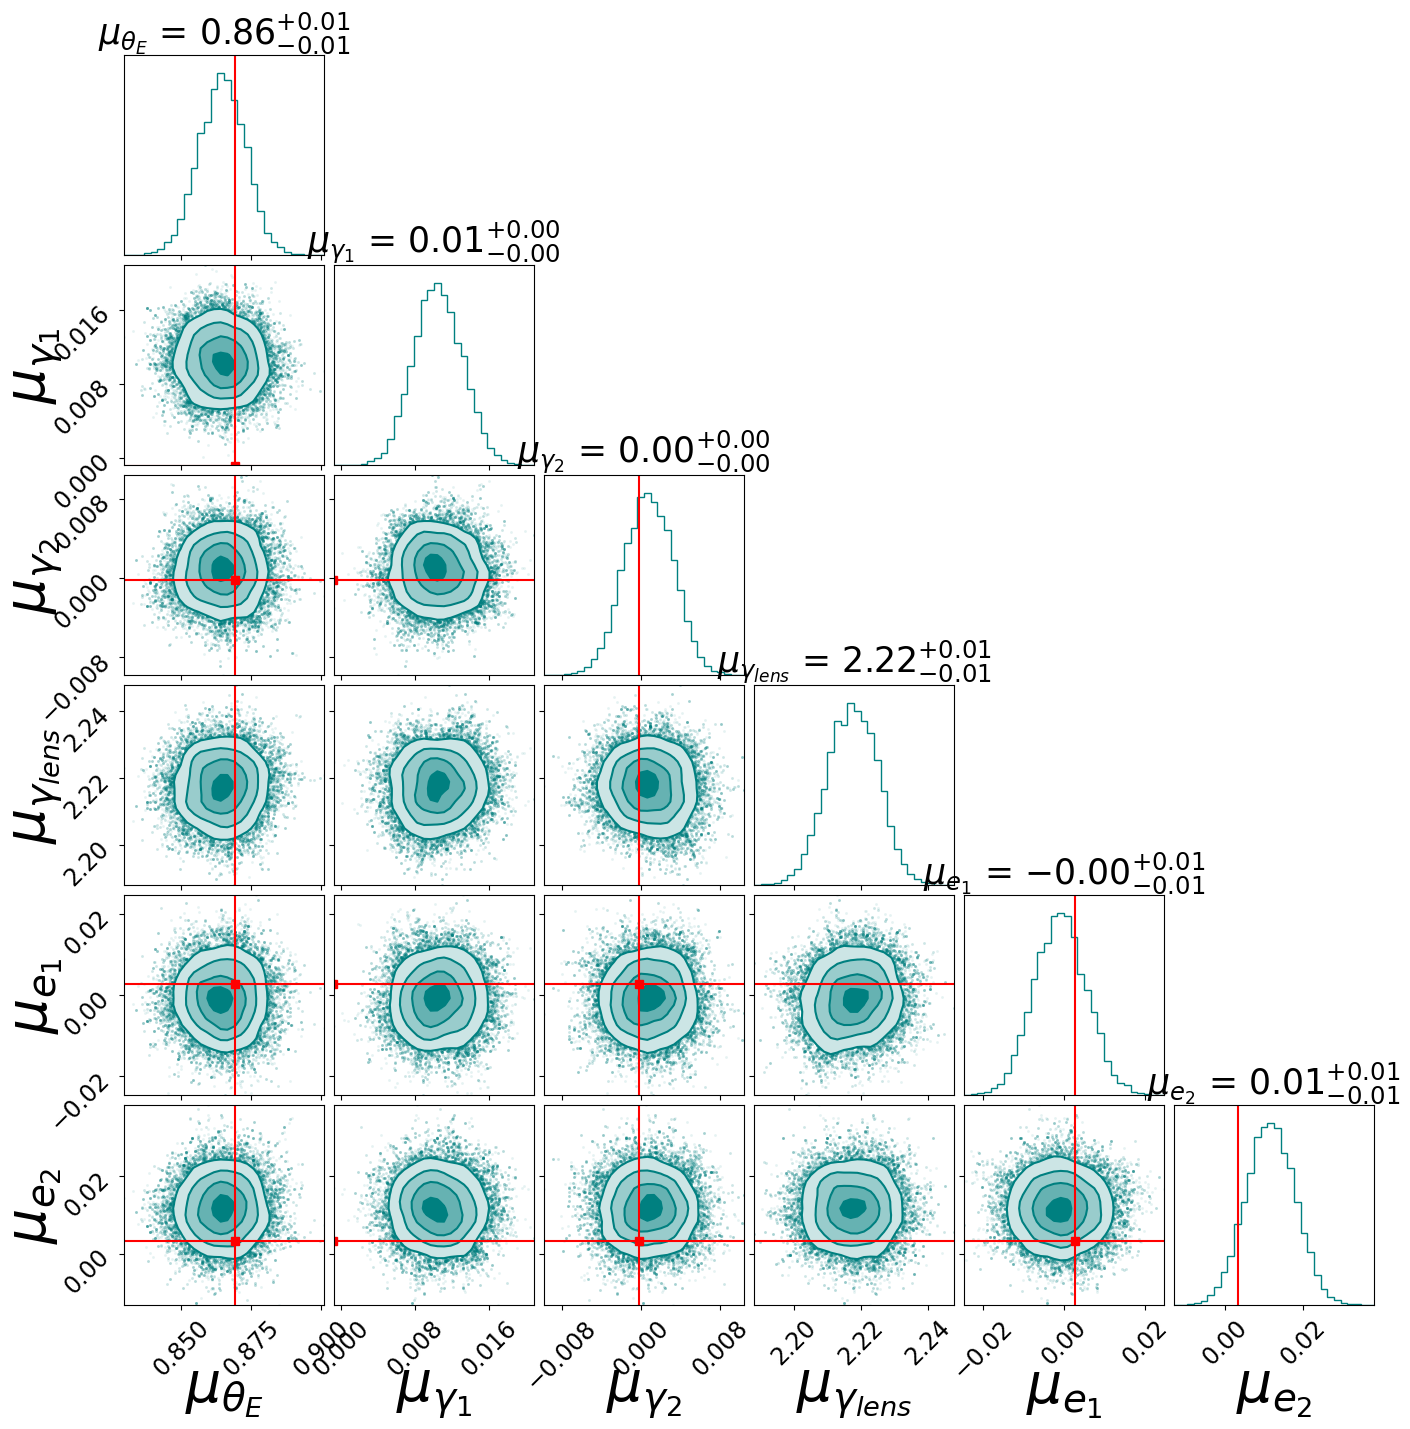

In [55]:
burnin = 500
mu_chains = emcee_chain[:, burnin:, :6]
std_chains = emcee_chain[:, burnin:, 6:]
CORNER_KWARGS = dict(
    smooth = 0.9,
    label_kwargs=dict(fontsize=40),
    color='teal',
    plot_density=True,
    plot_datapoints=True,
    fill_contours=True,
    show_titles=True,
    max_n_ticks=3,
    bins=30
)

corner.corner(data = mu_chains.reshape(mu_chains.shape[0]*mu_chains.shape[1], mu_chains.shape[-1]), labels=mu_labels,truths=mu_test,truth_color='r', **CORNER_KWARGS);
#fig.tight_layout()

In [80]:
pd.DataFrame(y_test[:, :6], columns = trained.learning_params[:6]).describe().iloc[1:, :].T

mean       std       min       25%  \
main_deflector_parameters_theta_E  0.869123  0.333972  0.450033  0.600163   
main_deflector_parameters_gamma1  -0.000864  0.042827 -0.223941 -0.028830   
main_deflector_parameters_gamma2  -0.000244  0.042053 -0.150110 -0.030229   
main_deflector_parameters_gamma    2.002113  0.161238  1.671613  1.881900   
main_deflector_parameters_e1       0.002599  0.154300 -0.633167 -0.100030   
main_deflector_parameters_e2       0.003200  0.158088 -0.600083 -0.091240   

                                        50%       75%       max  
main_deflector_parameters_theta_E  0.785414  1.049425  2.009574  
main_deflector_parameters_gamma1  -0.001282  0.028587  0.187337  
main_deflector_parameters_gamma2  -0.000960  0.031366  0.147810  
main_deflector_parameters_gamma    2.006295  2.124142  2.329444  
main_deflector_parameters_e1       0.004821  0.106033  0.567674  
main_deflector_parameters_e2      -0.000641  0.104786  0.714653

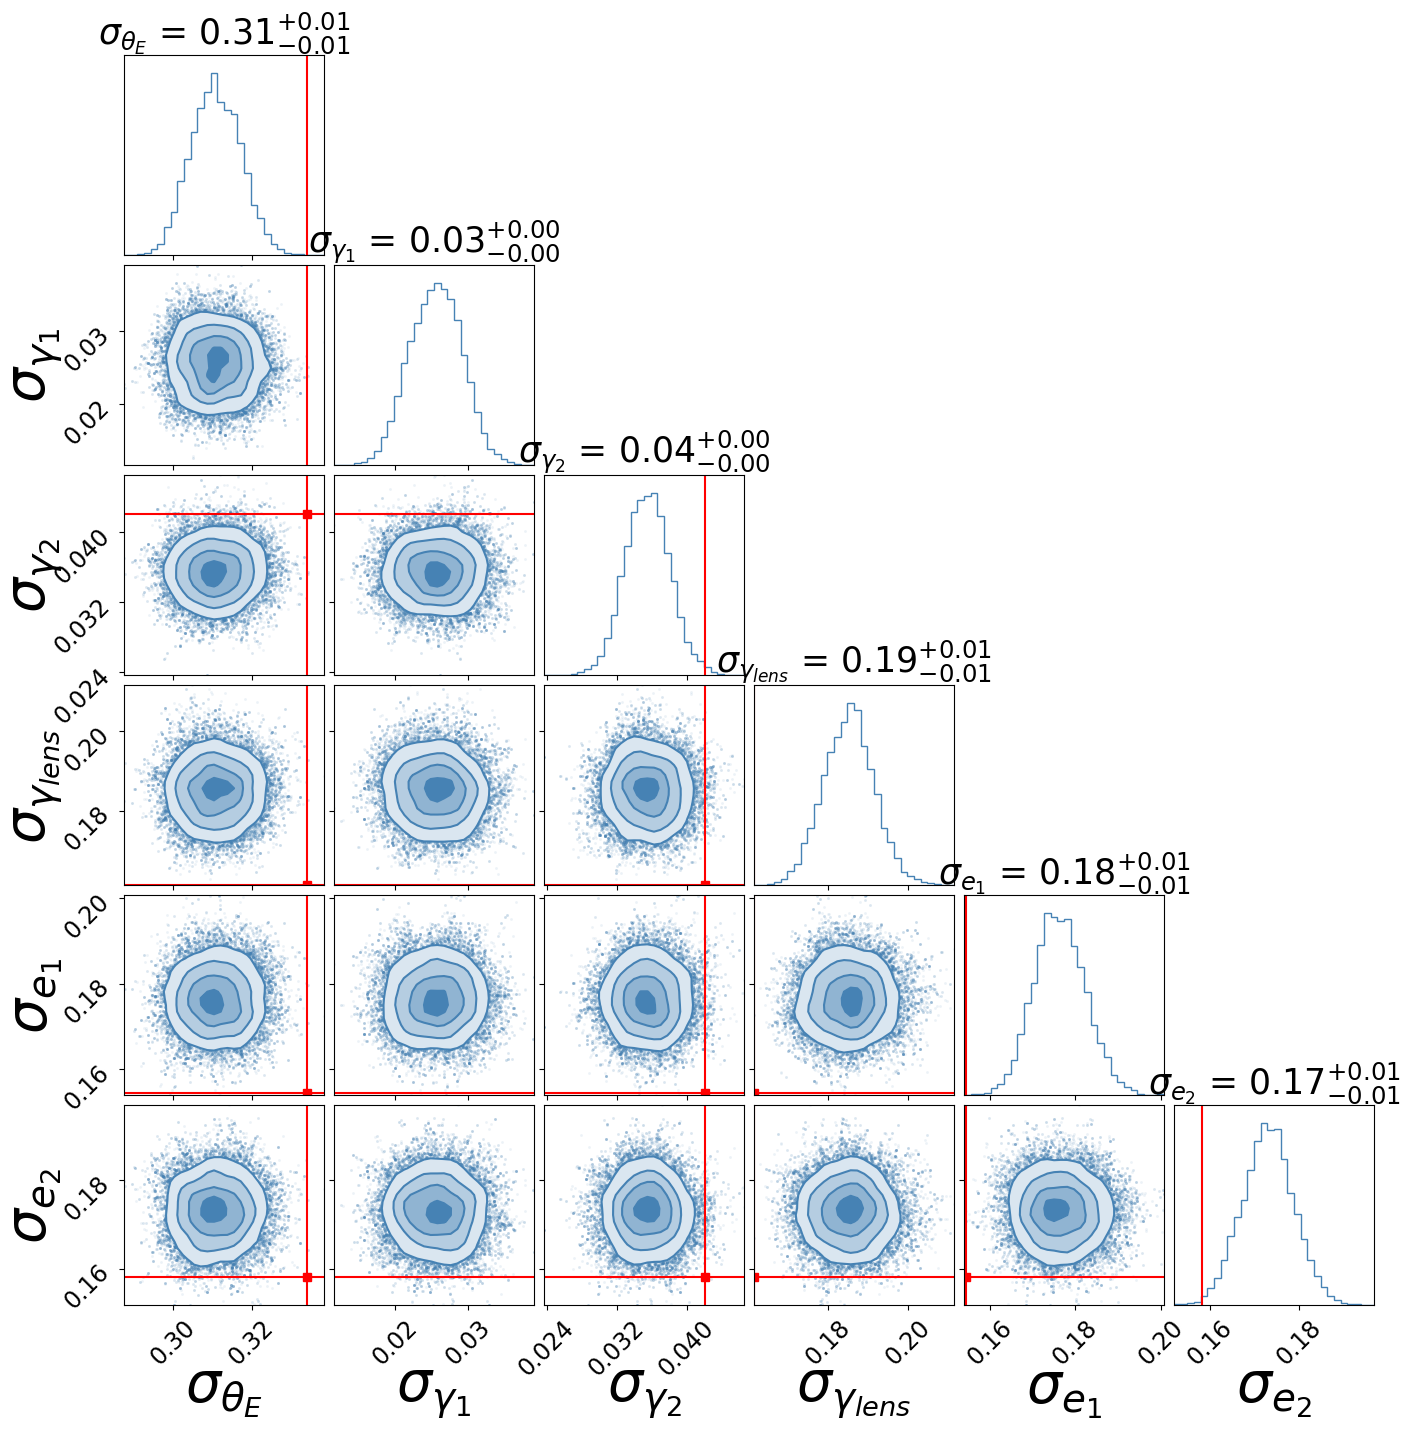

In [53]:
burnin = 500
mu_chains = emcee_chain[:, burnin:, :6]
std_chains = emcee_chain[:, burnin:, 6:]
CORNER_KWARGS = dict(
    smooth = 0.9,
    label_kwargs=dict(fontsize=40),
    color='steelblue',
    plot_density=True,
    plot_datapoints=True,
    fill_contours=True,
    show_titles=True,
    max_n_ticks=3,
    bins=30
)

corner.corner(data = std_chains.reshape(std_chains.shape[0]*std_chains.shape[1], std_chains.shape[-1]), labels=std_labels,truths=std_test,truth_color='red', **CORNER_KWARGS);


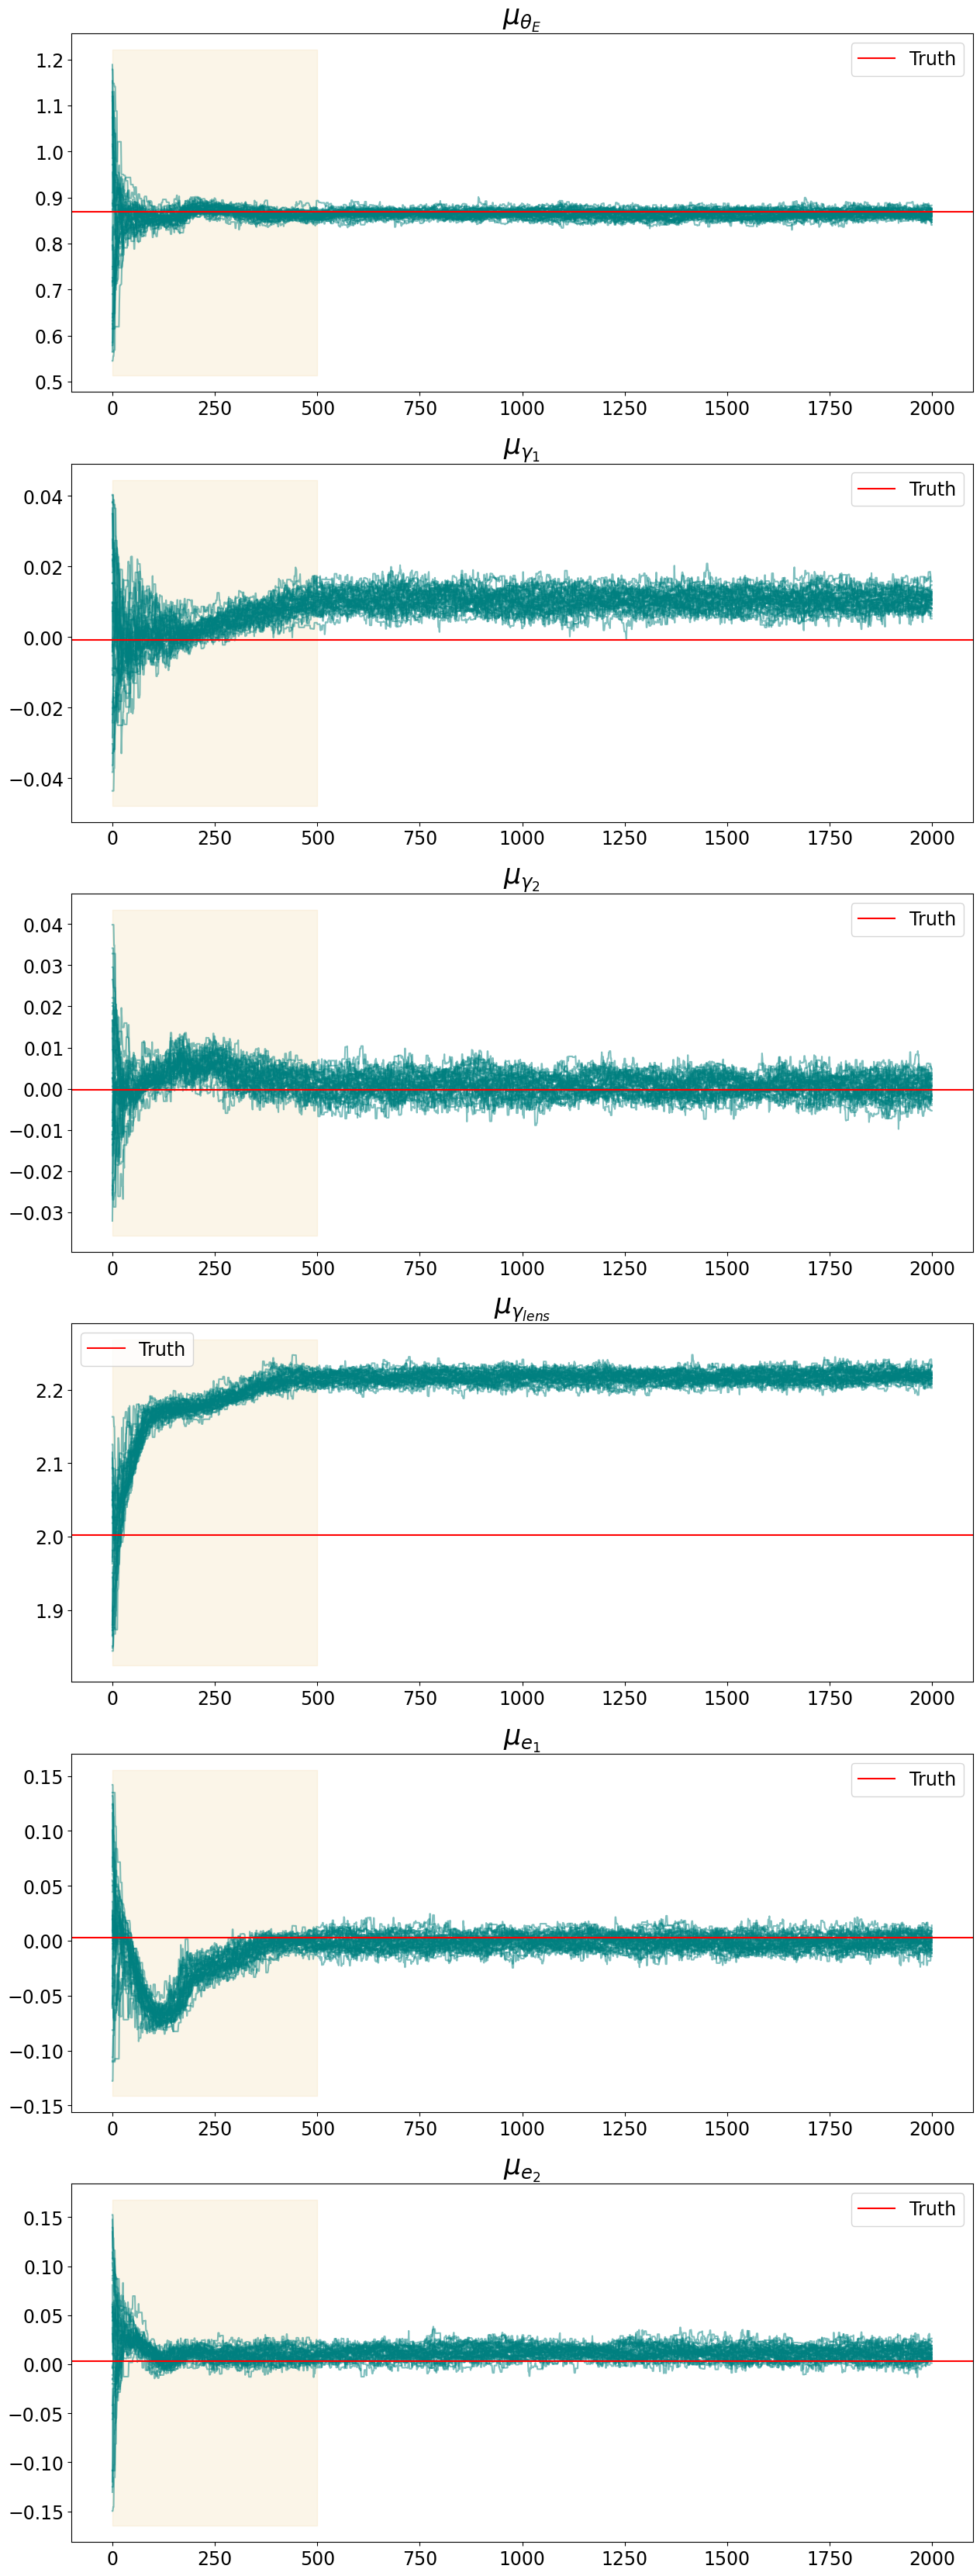

In [71]:
burnin = 0
mu_chains = emcee_chain[:, burnin:, :6]
std_chains = emcee_chain[:, burnin:, 6:]
fig, ax = plt.subplots(6, 1,figsize = (15, 7*6) )
for i in range(mu_chains.shape[-1]):
    ax[i].plot(mu_chains[:, :, i].T, alpha=0.5, color='teal')
    ax[i].axhline(mu_test[i], color='r', label='Truth')

    ax[i].set_title(mu_labels[i])
    ax[i].fill_betweenx(y = ax[i].get_ylim(), x1=0,x2=500, color='wheat', alpha=0.3)

    ax[i].legend()

In [61]:
%matplotlib inline

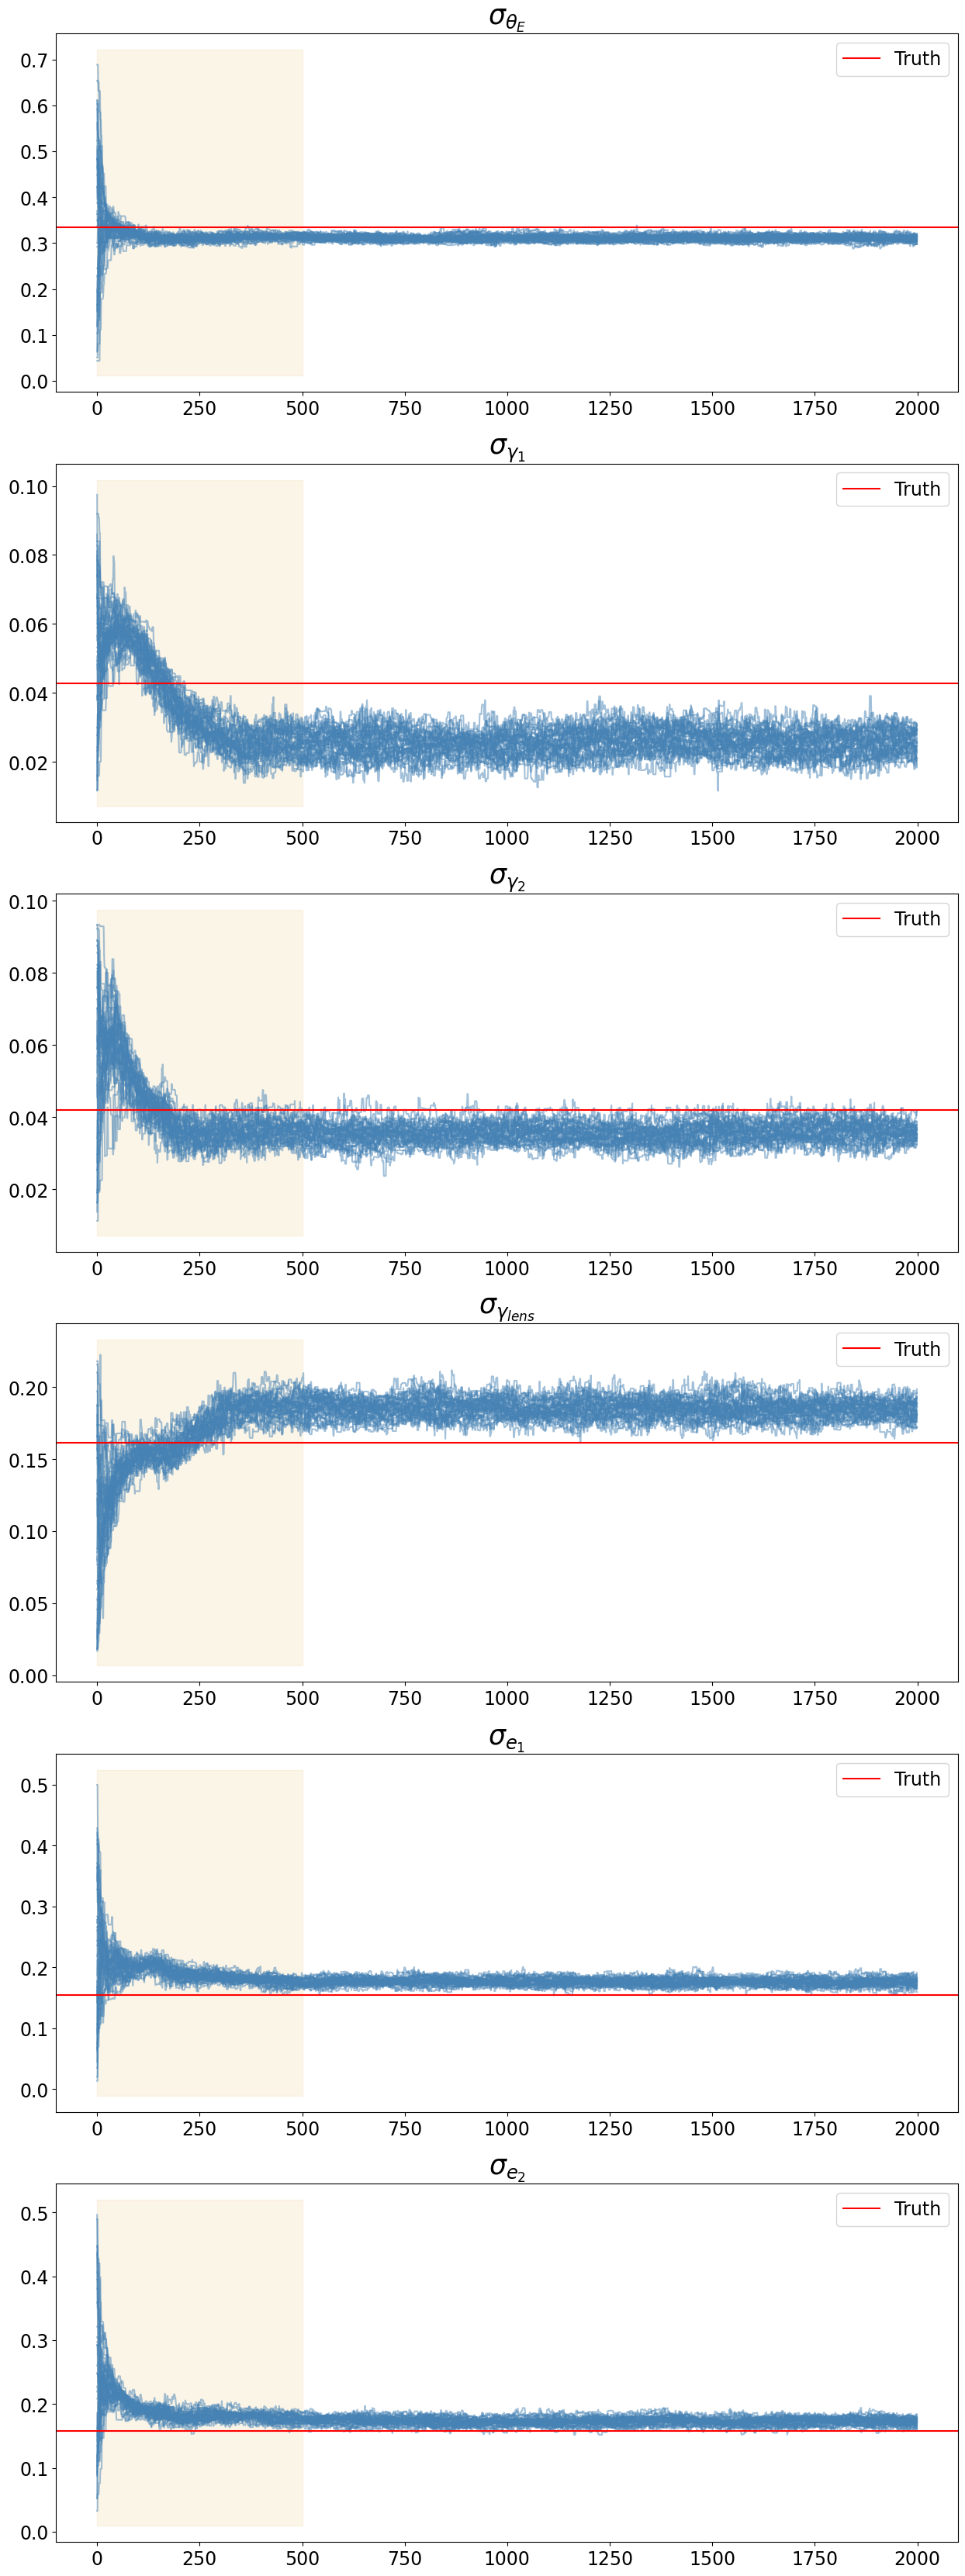

In [70]:
burnin = 0
mu_chains = emcee_chain[:, burnin:, :6]
std_chains = emcee_chain[:, burnin:, 6:]
fig, ax = plt.subplots(6, 1,figsize = (15, 7*6) )
for i in range(std_chains.shape[-1]):
    ax[i].plot(std_chains[:, :, i].T, alpha=0.5, color='steelblue')
    ax[i].axhline(std_test[i], color='r', label='Truth')
    ax[i].set_title(std_labels[i])
    ax[i].fill_betweenx(y = ax[i].get_ylim(), x1=0,x2=500, color='wheat', alpha=0.3)
    ax[i].legend()

Let's visualize the constraints using `corner`

In [ ]:
corner_param_print=[r'$\Sigma_\mathrm{sub,pop} \times 10^{3}$' + '\n' + r'$[\mathrm{kpc}^{-2}]$',
                    r'$\log \Sigma_\mathrm{sub,pop,\sigma} \times 10^{3}$' + '\n' + r'$[\mathrm{kpc}^{-2}]$']
fontsize = 20
color='#FFAA00'
truth_color = 'k'
hist_kwargs = {'density':True,'color':color,'lw':3}

corner.corner(chain,labels=corner_param_print,bins=20,show_titles=False,plot_datapoints=False,label_kwargs=dict(fontsize=fontsize),
              levels=[0.68,0.95],color=color,fill_contours=True,hist_kwargs=hist_kwargs,title_fmt='.2f',truths=true_hyperparameters,
              truth_color=truth_color,max_n_ticks=3)
plt.show()

You have an unbiased inference of the mean, and it's clear from this data that the constrain on the scatter is an upper limit (not suprising given the small scatter and the large uncertainty of the information we assigned to each data point). 